# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2022/23 (6 CFU) - Dr. Jacopo Pegoraro, Dr. Daniele Mari
---


# Inception Neural Networks

**Inception-v4 network.** This architecture was proposed by [Google developers](https://arxiv.org/pdf/1602.07261.pdf) for image classification.

**In this assignment, you will:**
- Implement the basic building blocks of Inception-v4. 
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification. 

The dataset is shared here https://drive.google.com/drive/folders/1fAnEoHWYetbyO5-grMmvabGjLUMgrS-Q?usp=share_link. Add a shortcut to your own google drive and mount drive on google colab. this way you should be able to access the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls
! cp /content/drive/MyDrive/dataset_nndl/camelyon* ./
! mv camelyonpatch_level_2_split_test_y.h5.gz.gzip  camelyonpatch_level_2_split_test_y.h5.gz
! mv camelyonpatch_level_2_split_valid_y.h5.gz.gzip  camelyonpatch_level_2_split_valid_y.h5.gz
! mv camelyonpatch_level_2_split_train_y.h5.gz.gzip  camelyonpatch_level_2_split_train_y.h5.gz
! gzip -df camelyonpatch_level_2_split_test_x.h5.gz 
! gzip -df camelyonpatch_level_2_split_test_y.h5.gz 
! gzip -df camelyonpatch_level_2_split_valid_x.h5.gz 
! gzip -df camelyonpatch_level_2_split_valid_y.h5.gz
! gzip -df camelyonpatch_level_2_split_train_x.h5.gz 
! gzip -df camelyonpatch_level_2_split_train_y.h5.gz

drive  sample_data


# Dataset
For this lab you will use the [**PatchCamelyon** dataset](https://github.com/basveeling/pcam). It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue.
A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

In this notebook you will use a smaller version of the dataset that consists of 1.200 images. Feel free to download the entire dataset to experiment with it (e.g., if you train the network with more examples, the performance of the designed classifier should increase).

The function `load_data()` defined in `resnet_utils.py`, loads the smaller dataset.

In [3]:
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
import torch
import os
import pandas as pd
import h5py
import random
import numpy as np

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
transforms = Compose([
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

In [5]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
class ImageDataset(Dataset):

    def __init__(self, dataset_folder, dataset_type, transform=None):
        self.x = h5py.File(os.path.join(dataset_folder, f'camelyonpatch_level_2_split_{dataset_type}_x.h5'), 'r')['x']
        self.y = h5py.File(os.path.join(dataset_folder, f'camelyonpatch_level_2_split_{dataset_type}_y.h5'), 'r')['y']
        self.transform = transform
    
    def __len__(self):
        return min(32000, len(self.x))
        #return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx, 0, 0].astype(float)
        if self.transform:
            x = self.transform(x)
        return x, y

In [6]:
train_dataset =  ImageDataset("./", "train", transforms)
valid_dataset =  ImageDataset("./", "valid", ToTensor())
test_dataset =  ImageDataset("./", "test", ToTensor())

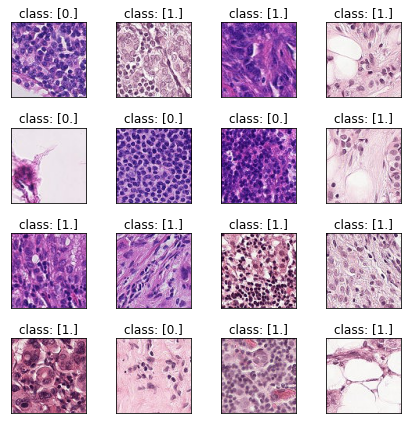

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"class: {train_dataset[i][1]}")
plt.tight_layout()

In [8]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())

# Inception network

In a pure Inception network there are two different block types: the *Inception blocks* and the *Reduction blocks*.

Inception-v4 is composed of three different Inception blocks, two Reduction ones and an initial stem block. 

<img src="https://developer.ridgerun.com/wiki/images/thumb/2/29/Inceptionv4.png/720px-Inceptionv4.png" width="500px">
<caption><center>  <br> </center></caption>

### Rationale behind Inception layers

Inception layers are usually built by runnining in parallel multiple different branches. 

The main improvements introduced by the inception network are the following:

* Since the various branches of a layer have filters of different sizes, they will focus on features with different scales. This is usually obtained by either increasing the kernel size of the filters or by stacking multiple Conv layers one after the other. For example by stacking two 3x3 layers the receptive field at the output is going to be 5x5. This considerably increases the feature extraction capability of the model.

* The 1x1 convolutional layers introduced before each branch are used to reduce considerably the total number of operations in the network (FLOPS). Consider the fact that a conv layer with kernel size NxN and F filters that processes an input of size HxWxC computes approximately N\*N\*F\*H\*W\*C operations. Given this it is possible to see that in general if we simply apply a NxN convolutional layer we get in total N\*N\*F\*H\*W\*C operations while by adding a 1x1 layer first that has a number of output filters F1 < C then we get a total number of operations equal to H\*W\*(F1\*C + N\*N\*F2\*F1) operations. It is easy to see that this is in general less FLOPs than when running a single NxN layer if F1 is small enough. Of course the bigger N the better the gain in terms of computational complexity. What the 1x1 convolutional filter actually does is that it performs dimensionality reduction since it is simply reducing the number of channels in the input representation while retaining as much information as possible.
For example in the Inception-A block the 1x1 convolution + 3x3 convolution reduces the total number of operations from 3\*3\*96\*H\*W\*384 = 331776\*H\*W
to H\*W(384\*64 + 3\*3\*64\*96) = 79872 \*H\*W  which is a 4x improvement and the gap increases considerably when we increase the filter size (e.g. 7x7)

* The authors have shown that expecially for big filters it is possible to reduce the overall number of FLOPs considerably at the price of very low performance loss by substituting NxN convolutional layers with two layers one with filters of size Nx1, and one with filters of size Nx1. The resulting receptive field is the same and the performance does not change much, however the total number of operations is 2\*N\*F\*H\*W\*C instead of N\*N\*F\*H\*W\*C. Additionally if the first layer also reduces the number of channels of the input then extra operations are saved.

* For the same reason also stacking multiple 3x3 layers is usually better than using a 5x5 or 7x7 layer in terms of number of operations while maintaining the same receptive field.

All of these tricks allow defining a very powerful model but that is much more efficient w.r.t. the naive definition that simply stacks NxN convolutions.


**Note**: for the last activation we will use ``sigmoid`` with one output neuron (binary classification task).

## 1 - Inception-v4 Building blocks 
### 1.1 - Convolutional and batch normalization helper function
First of all, here below is implemented the ``Conv2d_bn`` helper module that you will use in all the blocks of the Inception v4 network.

Use the following structure:
- CONV2D with $F$ filters of shape ($h$, $w$), stride of ($s_1$, $s_2$). 
- BatchNorm, normalizing the 'channels' axis.  
- ReLU activation function. 

In [9]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d
import collections
import torch
class Conv2d_bn(Module):

    def __init__(self, in_filters, out_filters, kernel_size, strides, padding):
        super().__init__()
        if isinstance(kernel_size, tuple):
            padding_val = (k // 2 for k in kernel_size) if padding == "same" else (0,0)
        else:
            padding_val = kernel_size // 2 if padding == "same" else 0
        self.conv = Conv2d (in_filters, out_filters, kernel_size, strides, padding_val)

        self.bn = BatchNorm2d(out_filters)
        self.relu = ReLU()
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

### 1.2 - The stem block

The stem block is designed as follows:

<p align="center">
  <img src="../imgs/stem.png" width="400" />
</p>

Implement below all the steps by taking advantage of the above implemented ``conv2d_bn`` function for the blue rectangles. 

- The values for the kernel sizes and the strides are specified in each block, use stride 1xs when it is not specified. 
- Use padding "valid" when the letter *V* appears otherwise use padding "same". 

E.g., the first layer has the following parameters: 32 filters of shape (3, 3), stride of (2, 2), padding "valid" while the third one is composed of 64 filters of shape (3, 3), stride of (1, 1), padding "same".

For the **Filter concat** layers (orange rectangles), use [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat) and concatenate along the 'channel' axis (axis=3).

**Note** that the last conv block has ``stride = 2`` and the max pooling layer has ``kernel = (3, 3)``

In [10]:
class StemBlock(Module):

    def __init__(self):
        super().__init__()
        self.first_block = Sequential(
            Conv2d_bn(in_filters=3, out_filters=32, kernel_size=3, strides=2, padding="valid"),
            Conv2d_bn(in_filters=32, out_filters=32, kernel_size=3, strides=1, padding="valid"),
            Conv2d_bn(in_filters=32, out_filters=64, kernel_size=3, strides=1, padding="same"),
        )
        self.first_left = MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.first_right = Conv2d_bn(in_filters=64, out_filters=96, kernel_size=3, strides=2, padding="valid")
        self.second_left =  Sequential(
            Conv2d_bn(in_filters=160, out_filters=64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=96, kernel_size=3, strides=1, padding="valid"),
        )
        self.second_right =  Sequential(
            Conv2d_bn(in_filters=160, out_filters=64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=64, kernel_size=(7, 1), strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=64, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=96, kernel_size=3, strides=1, padding="valid"),
        )
        self.third_left = Conv2d_bn(in_filters=192, out_filters=192, kernel_size=3, strides=2, padding="valid")
        self.third_right = MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x = self.first_block(x)
        x_l = self.first_left(x)
        x_r = self.first_right(x)
        x = torch.cat([x_l, x_r], axis=1)
        x_l = self.second_left(x)
        x_r = self.second_right(x)
        x = torch.cat([x_l, x_r], axis=1)
        x_l = self.third_left(x)
        x_r = self.third_right(x)
        x = torch.cat([x_l, x_r], axis=1)
        return x

In [11]:
model = StemBlock()
print(model(torch.zeros((1, 3, 299, 299))).shape)
print(f"Expected shape (1, 384, 35, 35)")

torch.Size([1, 384, 35, 35])
Expected shape (1, 384, 35, 35)


### 1.3 - The Inception-A block

Implement below the Inception-A block as in the figure:

<img src="https://drive.google.com/uc?export=download&id=1wth4q2nf9h4d4JTwmrAhLVzb5pFyIRCd" width="600px">
<caption><center> Inception-A block. </center></caption>

**Note** The average pooling has ``pool_size = (3, 3)`` and ``strides = (1, 1)``

In [17]:
from torch.nn import MaxPool2d, AvgPool2d, Linear, Dropout

class A_block(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.avg_block = Sequential(
            AvgPool2d(kernel_size=3, stride=1, padding=1),
            Conv2d_bn(in_filters=in_filters, out_filters=96, kernel_size=1, strides=1, padding="same"),
        )
        self.one_by_one_block = Conv2d_bn(in_filters=in_filters, out_filters=96, kernel_size=1, strides=1, padding="same")
        self.three_by_three_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=96, kernel_size=3, strides=1, padding="same"),
        )
        self.five_by_five =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=64, out_filters=96, kernel_size=3, strides=1, padding="same"),
            Conv2d_bn(in_filters=96, out_filters=96, kernel_size=3, strides=1, padding="same"),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
    def forward(self, x):
        x_1 = self.avg_block(x)
        x_2 = self.one_by_one_block(x)
        x_3 = self.three_by_three_block(x)
        x_4 = self.five_by_five(x)
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)
        return x

In [18]:
a_block = A_block(384)
print(a_block(torch.zeros(1, 384, 35, 35)).shape)
print(f"Expected shape (1, 384, 35, 35)")

torch.Size([1, 384, 35, 35])
Expected shape (1, 384, 35, 35)


### 1.4 - The Inception-B block

Implement below the Inception-B block as in the figure:

<img src="https://drive.google.com/uc?export=download&id=1j5W2jqmXblyDkpQJ6lSo77NCA0AjiFDN" width="600px">
<caption><center> Inception-B block. </center></caption>

**Note** The average pooling has ``pool_size = (3, 3)`` and ``strides = (1, 1)``. In the third branch, the last convolutional layer has kernel of size (7, 1).

In [19]:
class B_block(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.avg_block = Sequential(
            AvgPool2d(kernel_size=3, stride=1, padding=1),
            Conv2d_bn(in_filters=in_filters, out_filters=128, kernel_size=1, strides=1, padding="same"),
        )
        self.one_by_one_block = Conv2d_bn(in_filters=in_filters, out_filters=384, kernel_size=1, strides=1, padding="same")

        self.seven_by_seven_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=192, out_filters=224, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(in_filters=224, out_filters=256, kernel_size=(7, 1), strides=1, padding="same"),
        )

        self.thirteen_by_thirteen_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=192, out_filters=192, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(in_filters=192, out_filters=224, kernel_size=(7, 1), strides=1, padding="same"),
            Conv2d_bn(in_filters=224, out_filters=224, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(in_filters=224, out_filters=256, kernel_size=(7, 1), strides=1, padding="same"),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
    
    def forward(self, x):
        x_1 = self.avg_block(x)
        x_2 = self.one_by_one_block(x)
        x_3 = self.seven_by_seven_block(x)
        x_4 = self.thirteen_by_thirteen_block(x)
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)
        return x

In [20]:
b_block = B_block(1024)
print(b_block(torch.zeros(1, 1024, 17, 17)).shape)
print(f"Expected shape (1, 1024, 17, 17)")

torch.Size([1, 1024, 17, 17])
Expected shape (1, 1024, 17, 17)


### 1.5 - The Inception-C block

Implement below the Inception-C block as in the figure:

<p align="center">
 <img src="../imgs/inception_C.png" width="700" />
</p>

**Note** The average pooling has ``pool_size = (3, 3)`` and ``strides = (1, 1)``.

In [21]:
class C_block(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.avg_block = Sequential(
            AvgPool2d(kernel_size=3, stride=1, padding=1),
            Conv2d_bn(in_filters=in_filters, out_filters=256, kernel_size=1, strides=1, padding="same"),
        )
        self.one_by_one_block = Conv2d_bn(in_filters=in_filters, out_filters=256, kernel_size=1, strides=1, padding="same")

        self.branch_a =  Conv2d_bn(in_filters=in_filters, out_filters=384, kernel_size=1, strides=1, padding="same")
        self.branch_a_left = Conv2d_bn(in_filters=384, out_filters=256, kernel_size=(1, 3), strides=1, padding="same")
        self.branch_a_right = Conv2d_bn(in_filters=384, out_filters=256, kernel_size=(3, 1), strides=1, padding="same")

        self.branch_b =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=384, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=384, out_filters=448, kernel_size=(1, 3), strides=1, padding="same"),
            Conv2d_bn(in_filters=448, out_filters=512, kernel_size=(3, 1), strides=1, padding="same"),
        )

        self.branch_b_left = Conv2d_bn(in_filters=512, out_filters=256, kernel_size=(1, 3), strides=1, padding="same")
        self.branch_b_right = Conv2d_bn(in_filters=512, out_filters=256, kernel_size=(3, 1), strides=1, padding="same")
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_1 = self.avg_block(x)
        x_2 = self.one_by_one_block(x)
        x_a = self.branch_a(x)
        x_3 = self.branch_a_left(x_a)
        x_4 = self.branch_a_right(x_a)
        x_b = self.branch_b(x)
        x_5 = self.branch_b_left(x_b)
        x_6 = self.branch_b_right(x_b)
        x = torch.cat([x_1, x_2, x_3, x_4, x_5, x_6], axis=1)
        return x

In [22]:
c_block = C_block(1536)
print(c_block(torch.zeros(1, 1536, 8, 8)).shape)
print(f"Expected shape (1, 1536, 8, 8)")

torch.Size([1, 1536, 8, 8])
Expected shape (1, 1536, 8, 8)


### 1.6 - The Reduction-A block

Implement below the Reduction-A block as in the figure:

<img src="https://drive.google.com/uc?export=download&id=1LtkLxcBOyJtVBikmY-ljspXhwCZlkHF1" width="600px">
<caption><center> Reduction-A block. </center></caption>

For the Inception-v4 the parameters are as follows:
- n = 384
- k = 192
- l = 224
- m = 256

In [23]:
class Reduction_A(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.max_pool = MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.central_block = Conv2d_bn(in_filters=in_filters, out_filters=384, kernel_size=3, strides=2, padding="valid")
        self.right_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=192, out_filters=224, kernel_size=3, strides=1, padding="same"),
            Conv2d_bn(in_filters=224, out_filters=256, kernel_size=3, strides=2, padding="valid"),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_1 = self.max_pool(x)
        x_2 = self.central_block(x)
        x_3 = self.right_block(x)
        x = torch.cat([x_1, x_2, x_3], axis=1)
        return x

In [24]:
reduction_A = Reduction_A(384)
print(reduction_A(torch.zeros(1, 384, 35, 35)).shape)
print("Expected shape (1, 1024, 17, 17)")

torch.Size([1, 1024, 17, 17])
Expected shape (1, 1024, 17, 17)


### 1.7 - The Reduction-B block

Implement below the Reduction-B block as in the figure:

<img src="https://drive.google.com/uc?export=download&id=18qKx5NE0i6U41EZnFhejYcTRnS_jlzp4" width="600px">

<caption><center> Reduction-B block. </center></caption>

In [25]:
class Reduction_B(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.max_pool = MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.central_block = Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=192, out_filters=192, kernel_size=3, strides=2, padding="valid"),
        )
        self.right_block =  Sequential(
            Conv2d_bn(in_filters=in_filters, out_filters=256, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(in_filters=256, out_filters=256, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(in_filters=256, out_filters=320, kernel_size=(7, 1), strides=1, padding="same"),
            Conv2d_bn(in_filters=320, out_filters=320, kernel_size=3, strides=2, padding="valid"),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_1 = self.max_pool(x)
        x_2 = self.central_block(x)
        x_3 = self.right_block(x)
        x = torch.cat([x_1, x_2, x_3], axis=1)
        return x

In [26]:
reduction_B = Reduction_B(1024)
print(reduction_B(torch.zeros(1, 1024, 17, 17)).shape)
print("Expected shape (1, 1536, 8, 8)")

torch.Size([1, 1536, 8, 8])
Expected shape (1, 1536, 8, 8)


In [27]:
from torch.nn import Dropout
class InceptionV4(Module):

    def __init__(self):
        super().__init__()
        self.stem = StemBlock()
        self.inception_a = Sequential(
            A_block(384),
            A_block(384),
            A_block(384),
            A_block(384)
        )
        self.reduction_a = Reduction_A(384)
        self.inception_b = Sequential(
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024)
        )
        self.reduction_b = Reduction_B(1024)
        self.inception_c = Sequential(
            C_block(1536),
            C_block(1536),
            C_block(1536)
        )
        self.drop = Dropout(0.2)
        self.out = Linear(1536, 1)
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.inception_a(x)
        x = self.reduction_a(x)
        x = self.inception_b(x)
        x = self.reduction_b(x)
        x = self.inception_c(x)
        x = x.reshape(x.shape[0], -1, 1536).mean(axis=1)
        x = self.drop(x)
        y = self.out(x)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

In [28]:
inception_v4 = InceptionV4()
print(inception_v4(torch.zeros(1, 3, 299, 299)).shape)
print("Expected shape (1, 1)")


torch.Size([1, 1])
Expected shape (1, 1)


In [30]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm


model = InceptionV4()
opt = SGD(model.parameters(), lr=0.005)
loss_fn = BCEWithLogitsLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs=10
best_val = np.inf
for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_pred = model(batch_x)

        loss = loss_fn(y_pred, batch_y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
        print(f"loss: {val_loss}, accuracy: {val_acc}")
    
    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "model.pt")
        best_val = val_loss

Epoch: 1


100%|██████████| 500/500 [00:31<00:00, 16.04it/s]


loss: 0.5042306086536773, accuracy: 0.7436875104904175
Saved Model
Epoch: 2


100%|██████████| 500/500 [00:31<00:00, 16.11it/s]


loss: 0.4875265664933322, accuracy: 0.7764062881469727
Saved Model
Epoch: 3


100%|██████████| 500/500 [00:30<00:00, 16.29it/s]


loss: 0.46948050885265, accuracy: 0.7767812609672546
Saved Model
Epoch: 4


100%|██████████| 500/500 [00:31<00:00, 15.86it/s]


loss: 0.5007865184337845, accuracy: 0.7472187876701355
Epoch: 5


100%|██████████| 500/500 [00:30<00:00, 16.14it/s]


loss: 0.47093330129532923, accuracy: 0.7698750495910645
Epoch: 6


100%|██████████| 500/500 [00:29<00:00, 16.79it/s]


loss: 0.4543184567245298, accuracy: 0.7850625514984131
Saved Model
Epoch: 7


100%|██████████| 500/500 [00:30<00:00, 16.25it/s]


loss: 0.4559401616084724, accuracy: 0.7931562662124634
Epoch: 8


100%|██████████| 500/500 [00:29<00:00, 16.97it/s]


loss: 0.4277410192567022, accuracy: 0.79234379529953
Saved Model
Epoch: 9


100%|██████████| 500/500 [00:31<00:00, 15.66it/s]


loss: 0.46089647892341384, accuracy: 0.7697500586509705
Epoch: 10


100%|██████████| 500/500 [00:30<00:00, 16.47it/s]

loss: 0.4659038990305071, accuracy: 0.771906316280365


In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score

def evaluate_network(dataloader, model, data_split):
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        loss = loss_fn(predictions, true).detach().cpu().numpy()
        predictions = torch.sigmoid(predictions).detach().cpu().numpy()
        true = true.detach().cpu().numpy()

        fpr, tpr, thresholds = roc_curve(true, predictions)
        auc = roc_auc_score(true, predictions)
        predictions = predictions.round()
        precision, recall, fscore, _= precision_recall_fscore_support(true, predictions, average='binary')
        accuracy = accuracy_score(true, predictions)

        print(f"{data_split} loss: {loss}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {fscore}, roc_auc: {auc}")

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{data_split} receiver operating characteristic (ROC)')
        plt.legend(loc="lower right")

100%|██████████| 500/500 [00:53<00:00,  9.37it/s]


Training Dataset loss: 0.356772026606106, accuracy: 0.84653125, precision: 0.8397502601456815, recall: 0.8567949038221334, f1: 0.848186960957062, roc_auc: 0.922267514869227


100%|██████████| 500/500 [00:30<00:00, 16.43it/s]


Validation Dataset loss: 0.4277410192567022, accuracy: 0.79234375, precision: 0.8129988597491448, recall: 0.7586055826761797, f1: 0.7848609447340305, roc_auc: 0.8858325263396201


100%|██████████| 500/500 [00:39<00:00, 12.67it/s]


Test Dataset loss: 0.4478119370774875, accuracy: 0.79525, precision: 0.8177777777777778, recall: 0.7594746716697937, f1: 0.7875486381322958, roc_auc: 0.877345981385149


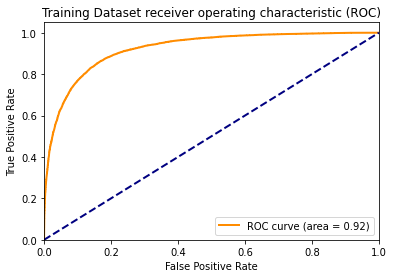

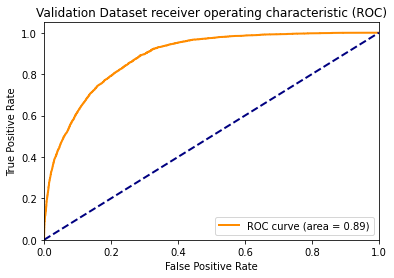

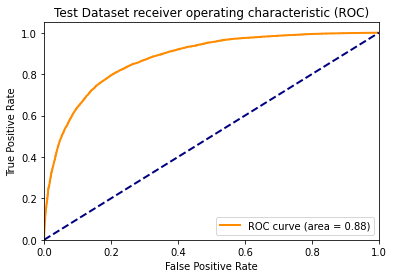

In [34]:
model.load_state_dict(torch.load("model.pt"))
evaluate_network(train_dataloader, model, "Training Dataset")
evaluate_network(valid_dataloader, model, "Validation Dataset")
evaluate_network(test_dataloader, model, "Test Dataset")